<a href="https://colab.research.google.com/github/alonsosilvaallende/Random-Survival-Forest-GBCSG2/blob/master/Cox_PH_and_RSF-just-code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pip install -q scikit-survival

     |████████████████████████████████| 7.1MB 2.8MB/s 


In [0]:
from sksurv.datasets import load_gbsg2

X, y = load_gbsg2()

In [5]:
X.head(10).style.hide_index()

age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
70.000000,66.000000,no,Post,3.000000,48.000000,II,21.000000
56.000000,77.000000,yes,Post,7.000000,61.000000,II,12.000000
58.000000,271.000000,yes,Post,9.000000,52.000000,II,35.000000
59.000000,29.000000,yes,Post,4.000000,60.000000,II,17.000000
73.000000,65.000000,no,Post,1.000000,26.000000,II,35.000000
32.000000,13.000000,no,Pre,24.000000,0.000000,III,57.000000
59.000000,0.000000,yes,Post,2.000000,181.000000,II,8.000000
65.000000,25.000000,no,Post,1.000000,192.000000,II,16.000000
80.000000,59.000000,no,Post,30.000000,0.000000,II,39.000000
66.000000,3.000000,no,Post,7.000000,0.000000,II,18.000000


In [6]:
y[:10]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [7]:
df_y = pd.DataFrame(data={'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
df_y[:10].style.hide_index().highlight_min('event', color='lightgreen')

time,event
1814.000000,True
2018.000000,True
712.000000,True
1807.000000,True
772.000000,True
448.000000,True
2172.000000,False
2161.000000,False
471.000000,True
2014.000000,False


In [8]:
print(f'Number of samples: {len(df_y)}')
print(f'Number of right censored samples: {len(df_y.query("event == False"))}')
print(f'Percentage of right censored samples: {100*len(df_y.query("event == False"))/len(df_y):.1f}%')

Number of samples: 686
Number of right censored samples: 387
Percentage of right censored samples: 56.4%


In [9]:
from sklearn.model_selection import train_test_split

X_trn, X_test, y_trn, y_test = train_test_split(X, y, random_state=42)

print(f'Number of training samples: {len(y_trn)}')
print(f'Number of test samples: {len(y_test)}')

Number of training samples: 514
Number of test samples: 172


In [0]:
scaling_cols = [c for c in X.columns if X[c].dtype.kind in ['i', 'f']]
cat_cols = [c for c in X.columns if X[c].dtype.kind not in ["i", "f"]]

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    [('cat-preprocessor', OrdinalEncoder(), cat_cols),
    ('standard-scaler', StandardScaler(), scaling_cols)],
    remainder='passthrough', sparse_threshold=0)

In [12]:
from sklearn.pipeline import make_pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

cox = make_pipeline(preprocessor, CoxPHSurvivalAnalysis())
cox.fit(X_trn, y_trn)

ci_cox = concordance_index_censored(y_test["cens"], y_test["time"], cox.predict(X_test))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')

The c-index of Cox is given by 0.635


In [14]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'coxphsurvivalanalysis__alpha': reciprocal(0.1, 100),
}

model_random_search = RandomizedSearchCV(cox, param_distributions=param_distributions, n_iter=50, n_jobs=-1, cv=3, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of Cox using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of Cox using a RandomizedSearchCV is 0.646
The best set of parameters is: {'coxphsurvivalanalysis__alpha': 31.428808908401084}


In [15]:
alpha = model_random_search.best_params_['coxphsurvivalanalysis__alpha']
cox_best = make_pipeline(preprocessor, CoxPHSurvivalAnalysis(alpha=alpha))
cox_best.fit(X_trn, y_trn)

ci_cox = concordance_index_censored(y_test["cens"], y_test["time"], cox_best.predict(X_test))
print(f'The c-index of Cox is given by {ci_cox[0]:.3f}')

The c-index of Cox is given by 0.646


In [16]:
!pip install -q eli5

     |████████████████████████████████| 112kB 2.8MB/s 


In [17]:
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
perm = PermutationImportance(
    cox_best.steps[-1][1], n_iter=100).fit(preprocessor.fit_transform(X_trn),y_trn)

In [80]:
import eli5
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.0677 ± 0.0260,tgrade
0.0616 ± 0.0206,progrec
0.0169 ± 0.0131,horTh
0.0151 ± 0.0096,menostat
0.0058 ± 0.0084,age
0.0056 ± 0.0065,tsize
0.0037 ± 0.0040,pnodes
0.0005 ± 0.0017,estrec


In [0]:
data = perm.results_
data = pd.DataFrame(data, columns=X_trn.columns)
meds = data.median()
meds = meds.sort_values(ascending=False)
data = data[meds.index]

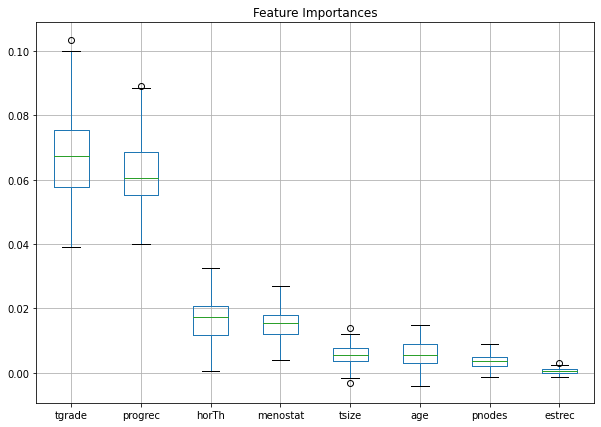

In [82]:
fig, ax = plt.subplots(figsize=(10,7))
data.boxplot(ax=ax)
ax.set_title('Feature Importances')
plt.show()

In [70]:
from sksurv.ensemble import RandomSurvivalForest

rsf = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42))
rsf.fit(X_trn, y_trn)
ci_rsf = concordance_index_censored(y_test["cens"], y_test["time"], rsf.predict(X_test))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.658


In [73]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

class reciprocal_int:
    def __init__(self, a, b):
        self._distribution = reciprocal(a, b)

    def rvs(self, *args, **kwargs):
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions1 = {
    'randomsurvivalforest__max_features': reciprocal_int(3, 8),
    'randomsurvivalforest__max_depth': reciprocal_int(5, 50),
    'randomsurvivalforest__min_samples_leaf': reciprocal_int(1, 40),
}

model_random_search = RandomizedSearchCV(
    rsf, param_distributions=param_distributions1, n_iter=50, n_jobs=-1, cv=3, random_state=42)
model_random_search.fit(X_trn, y_trn)

print(
    f"The c-index of random survival forest using a {model_random_search.__class__.__name__} is "
    f"{model_random_search.score(X_test, y_test):.3f}")
print(
    f"The best set of parameters is: {model_random_search.best_params_}"
)

The c-index of random survival forest using a RandomizedSearchCV is 0.641
The best set of parameters is: {'randomsurvivalforest__max_depth': 20, 'randomsurvivalforest__max_features': 3, 'randomsurvivalforest__min_samples_leaf': 1}


In [0]:
max_depth = model_random_search.best_params_['randomsurvivalforest__max_depth']
max_features = model_random_search.best_params_['randomsurvivalforest__max_features']
min_samples_leaf = model_random_search.best_params_['randomsurvivalforest__min_samples_leaf']

In [83]:
rsf_best = make_pipeline(preprocessor, RandomSurvivalForest(random_state=42, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf))
rsf_best.fit(X_trn, y_trn)
ci_rsf = concordance_index_censored(y_test["cens"], y_test["time"], rsf_best.predict(X_test))
print(f'The c-index of Random Survival Forest is given by {ci_rsf[0]:.3f}')

The c-index of Random Survival Forest is given by 0.641


In [74]:
rsf_best.steps[-1][1]

RandomSurvivalForest(bootstrap=True, max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None, min_samples_leaf=3,
                     min_samples_split=6, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=42, verbose=0, warm_start=False)

In [0]:
perm = PermutationImportance(
    rsf.steps[-1][1], n_iter=100).fit(preprocessor.fit_transform(X_trn),y_trn)

In [0]:
data = perm.results_
data = pd.DataFrame(data, columns=X_trn.columns)
meds = data.median()
meds = meds.sort_values(ascending=False)
data = data[meds.index]

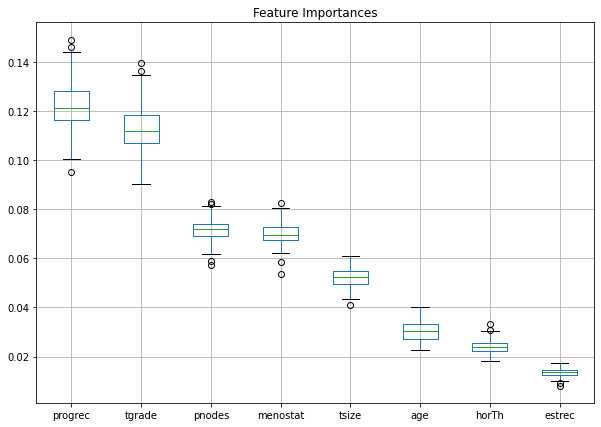

In [87]:
fig, ax = plt.subplots(figsize=(10,7))
data.boxplot(ax=ax)
ax.set_title('Feature Importances')
plt.show()

In [88]:
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1222 ± 0.0195,progrec
0.1125 ± 0.0188,tgrade
0.0712 ± 0.0096,pnodes
0.0698 ± 0.0097,menostat
0.0521 ± 0.0082,tsize
0.0304 ± 0.0083,age
0.0241 ± 0.0054,horTh
0.0134 ± 0.0034,estrec
